In [14]:
# import all relevant libraries dependencies and set up the backend
import qsharp
import numpy as np
import matplotlib
import sys
import time
import progressbar
import matplotlib.pyplot as plt
from qsharp import Result
from Quantum.Hubbard import Evolve, EvolveSingleTimestepDummy
import exact_diagonalisation.ed_hubbard as ED 
from cycler import cycler
%matplotlib inline

c1_a = '#003AF0'
c2_a = '#008F24'
c3_a = '#FE7B22'
c4_a = '#FE000C'
c5_a = '#FB30F2'
c6_a = '#82E0AA'
c7_a = '#9966CC'
c8_a = '#7FFFD4'
c9_a = '#66FF00'
c10_a = '#8B008B'
c11_a = '#000000'
colors = [c1_a, c2_a, c3_a, c4_a, c5_a, c6_a, c7_a, c8_a, c9_a, c10_a, c11_a]

In [24]:
# define system parameters
p = {}
p['L'] = 3 # system length
p['W'] = 2 # system width
p['N1'] = 2 # number of particles in 1
p['N2'] = 2 # number of particles in 2
p['t1'] = p['t2'] = J = 0.5 # hopping
p['U12'] = U = 0.3 # on-site interaction between 1 and 2
p['mu1'] = p['mu2'] = mu = 0.3 # chemical potential
p['t_initial'] = 0.0 # begin of time evolution
p['dt'] = dt = 0.005 # time-step
p['t_final'] = total_time = 1.0 # end of time evolution
p['N'] = N = p['L'] * p['W'] # system size
ave = 50
if p['W'] == 2:
    structure = 3
elif p['W'] == p['L']:
    structure = 4
else:
    structure = 1

In [26]:
# generate random initial state
state_table = ED.generate_state_table(p)
state_int = state_table[np.random.randint(len(state_table))]
initial_state = ED.int_to_state(p, state_int)
ED.project_state_into_spinsectors(initial_state)

array([[0, 0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 1]])

In [27]:
# do exact evolution
tic = time.time()
sim, state_table = ED.evolve(
    p, state_table, initial_state, kind="list",
    correlation_measurement=False, trotterised=True)
toc = time.time()
print("Exact evolution took ", toc-tic, "s")

Exact evolution took  33.21617674827576 s


In [28]:
# do qsharp evolution
tic = time.time()
times = np.linspace(0, total_time, num=10)
result_up = np.zeros((len(times), len(initial_state)))
result_down = np.zeros((len(times), len(initial_state)))
progress_bar = progressbar.ProgressBar(max_value=ave)
points_taken = 0
for _ in range(ave):
    for i, t in enumerate(times):
        res = Evolve.simulate(
            initialState=initial_state, time=t, dt=dt, mu=mu, U=U, J=J,
            structure=structure)
        result_up[i] += ED.project_state_into_spinsectors(res)[0] / ave
        result_down[i] += ED.project_state_into_spinsectors(res)[1] / ave
    points_taken += 1
    progress_bar.update(points_taken)
toc = time.time()
print("Q# Evolution took {} mins {} s".format(int((toc-tic) // 60), int((toc-tic) % 60)))

100% (50 of 50) |########################| Elapsed Time: 0:23:35 ETA:  00:00:00

Q# Evolution took 24 mins 1 s


<Figure size 432x288 with 0 Axes>

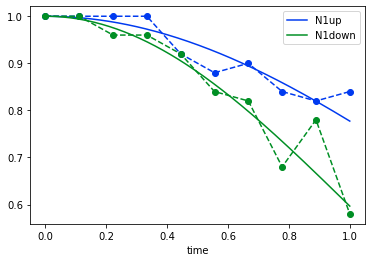

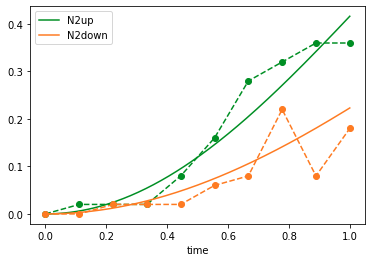

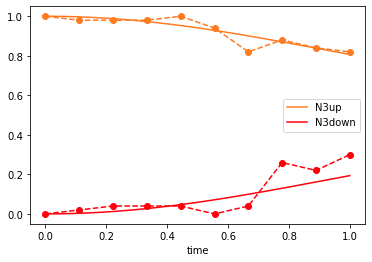

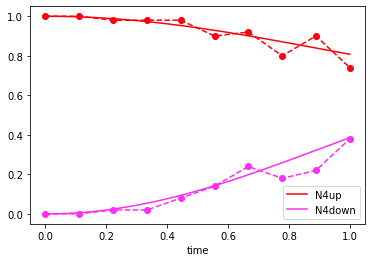

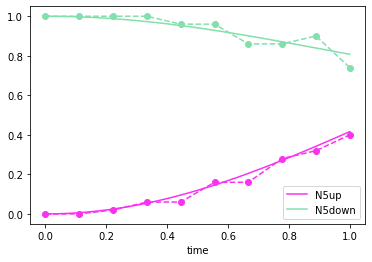

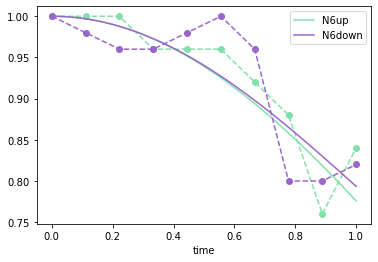

In [23]:
# plottable_times = np.append(np.array([0]), times)
fig = plt.figure()
for i in range(len(initial_state)):
    fig = plt.figure()
    plt.plot(sim['Time'], sim['Re(N1 Site {})'.format(i + 1)],
             color=colors[i], label='N{}up'.format(i + 1))
    plt.plot(times, result_up[:, i], 
             color=colors[i], marker='o', linestyle='--')
    plt.plot(sim['Time'], sim['Re(N2 Site {})'.format(i + 1)],
             color=colors[i + 1], label='N{}down'.format(i + 1))
    plt.plot(times, result_down[:, i], 
             color=colors[i + 1], marker='o', linestyle='--')
    plt.xlabel('time')
    plt.legend()

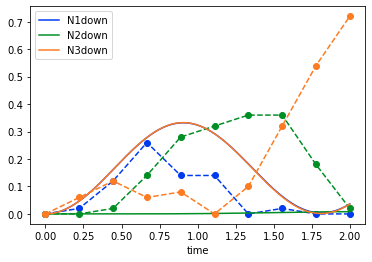

In [64]:
fig = plt.figure()
for i in range(len(initial_state[:3])):
    plt.plot(sim['Time'], sim['Re(N2 Site {})'.format(i + 1)],
             color=colors[i], label='N{}down'.format(i + 1))
    plt.plot(times, result_down[:, i], 
             color=colors[i], marker='o', linestyle='--')
plt.xlabel('time')
plt.legend()

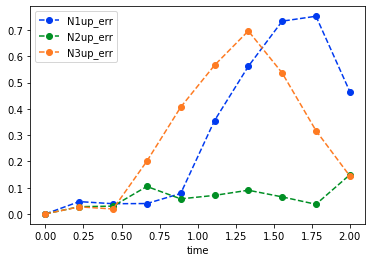

In [65]:
# plottable_times = np.append(np.array([0]), times)
inds = []
for i, t in enumerate(sim['Time']):
    if any([np.isclose(s, t, atol=0.0005) for s in times]):
        inds.append(i)
fig = plt.figure()
for i in range(len(initial_state[:3])):
    err = abs(sim['Re(N1 Site {})'.format(i + 1)][inds] - result_up[:, i])
#     plt.plot(sim['Time'],
#              sim['Re(N1 Site {})'.format(i + 1)][::10] - result_up[:, i],
#              color=colors[i], label='N{}up'.format(i + 1))
    plt.plot(times, err, 
             color=colors[i], marker='o', linestyle='--', label='N{}up_err'.format(i + 1))
plt.xlabel('time')
plt.legend()

In [ ]:
# estimate resources
full_gatecount = Evolve.estimate_resources(initialState=initial_state, time=t, dt=dt, mu=mu, U=U, J=J,
                                           structure=structure)
timestep_gatecount = EvolveSingleTimestepDummy.estimate_resources(
                        nSites=len(initial_state), dt=dt, mu=mu, U=U, J=J, structure=structure)

print('Full Evolution')
print(*['\t{}: {}\n'.format(k, v) for k, v in full_gatecount.items()])
print('Single Timestep')
print(*['\t{}: {}\n'.format(k, v) for k, v in timestep_gatecount.items()])